In [10]:
import cv2
import numpy as np
import dlib

def read_pts(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    landmarks = []

    for line in lines[3:-1]:
        x, y = map(float, line.strip().split())
        landmarks.append([x, y])
    
    return np.array(landmarks)
def draw_keypoints(image, landmarks, true_points, color=(0, 255, 0), radius=2, thickness=-1):
    image_out = image.copy()
    for (x, y) in landmarks:
        cv2.circle(image_out, (int(x), int(y)), radius, color, thickness)
    for (x, y) in true_points:
        cv2.circle(image_out, (int(x), int(y)), radius, color, thickness)
    return image_out
def evaluate_dlib(predictor, files, detector):
    predictions = []
    gt = []
    normalizations = []
    for file in files:
        from PIL import Image
        image = np.array(Image.open(file[0]))
        faces = detector(image)
        if len(faces) == 0:
            w, h = image.shape[:2]
            face_rect = dlib.rectangle(0, 0, w, h)
        else:
            face_rect = faces[0]
        x1, y1, x2, y2 = face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom()
        shape = predictor(image, face_rect)
        pred_points = np.array([[p.x, p.y] for p in shape.parts()])
        true_points = read_pts(file[1])
        H = y2 - y1
        W = x2 - x1
        norm_factor = np.sqrt(H * W)
        predictions.append(pred_points)
        gt.append(true_points)
        normalizations.append(norm_factor)

    return np.array(predictions), np.array(gt), np.array(normalizations)

def count_ced(predicted_points, gt_points, normalizations):
    ceds = []
    for preds, gts, normalization in zip(predicted_points, gt_points, normalizations):
        x_pred, y_pred = preds[:, ::2], preds[:, 1::2]
        x_gt, y_gt = gts[:, ::2], gts[:, 1::2]
        n_points = x_pred.shape[0]
        diff_x = [x_gt[i] - x_pred[i] for i in range(n_points)]
        diff_y = [y_gt[i] - y_pred[i] for i in range(n_points)]
        dist = np.sqrt(np.square(diff_x) + np.square(diff_y))
        avg_norm_dist = np.sum(dist) / (n_points * normalization)
        ceds.append(avg_norm_dist)
    ceds = np.sort(ceds)

    return ceds


In [11]:
from torch.utils.data import DataLoader
import torch
from dataset import FaceLandmarksDataset
from model import FaceAlignmentModel

def evaluate_model(model, loader):
    predictions = []
    gt = []
    normalizations = []
    model.eval()
    with torch.no_grad():
        for batch in loader:
            images = batch["image"].to('cuda')
            landmarks = batch["landmarks"]
            scale = batch["scale"]
            preds = model(images)
            for i in range(preds.shape[0]):
                face_rect = batch["face_rect"][i].cpu().numpy()
                scale_i = scale[i].cpu().numpy()
                pred_points = preds[i].cpu().numpy() * scale_i
                pred_points = pred_points + np.array([face_rect[0], face_rect[1]])
                true_points = landmarks[i].cpu().numpy() * scale_i
                true_points = true_points + np.array([face_rect[0], face_rect[1]])
                H = face_rect[3] - face_rect[1]
                W = face_rect[2] - face_rect[0]
                norm_factor = np.sqrt(H * W)
                predictions.append(pred_points)
                gt.append(true_points)
                normalizations.append(norm_factor)

    return np.array(predictions), np.array(gt), np.array(normalizations)

predictor = dlib.shape_predictor("data/shape_predictor_68_face_landmarks.dat")
detector = dlib.get_frontal_face_detector()
files = []
import config
for ds_name, folder in config.TEST_FOLDERS.items():
    files = []
    for ext in ["*.jpg", "*.png"]:
        for img_path in folder.glob(ext):
            pts_path = img_path.with_suffix(".pts")
            if pts_path.exists() and len(read_pts(str(pts_path))) == 68:
                files.append((img_path, pts_path))

    dataset = FaceLandmarksDataset(files, train=False)
    loader = DataLoader(dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=config.NUM_WORKERS)
    
    model = FaceAlignmentModel.load_from_checkpoint('outputs/checkpoints/efficientnet_mse.ckpt', map_location=torch.device('cuda'))
    preds, gt, normalizations = evaluate_model(model, loader)
    ceds = count_ced(preds, gt, normalizations)
    thresholds = np.linspace(0, 1, 100)
    ced_curve = np.array([np.mean(ceds < thr) for thr in thresholds])
    auc_model = np.trapezoid(ced_curve, thresholds)

    print('model', auc_model)
    
    if ds_name.lower() == "menpo":
        preds, gt, normalizations = evaluate_dlib(predictor, files, detector)
        ceds = count_ced(preds, gt, normalizations)
        ced_curve = np.array([np.mean(ceds < thr) for thr in thresholds])
        auc_dlib = np.trapezoid(ced_curve, thresholds)

        print('dlib', auc_dlib)

        # proportion = np.arange(ceds.shape[0], dtype=np.float32) / ceds.shape[0]
        # under_thr = ceds > 0.08
        # last_idx = len(ceds)
        # if len(np.flatnonzero(under_thr)) > 0:
        #     last_idx = np.flatnonzero(under_thr)[0]
        # under_thr_range = range(last_idx)
        # aucs = []

        # auc = 0
        # proportions = np.arange(len(ceds), dtype=np.float32) / len(ceds)
        # assert (len(proportions) > 0)

        # step = 0.01
        # for thr in np.arange(0.0, 1.0, step):
        #     gt_indexes = [idx for idx, e in enumerate(ceds) if e >= thr]
        #     if len(gt_indexes) > 0:
        #         first_gt_idx = gt_indexes[0]
        #     else:
        #         first_gt_idx = len(ceds) - 1
        #     auc += proportions[first_gt_idx] * step
        # aucs.append(auc)

model 0.9090113735783028
model 0.9365974418924499
dlib 0.92250034383166


In [3]:
auc_dlib

np.float64(0.92250034383166)

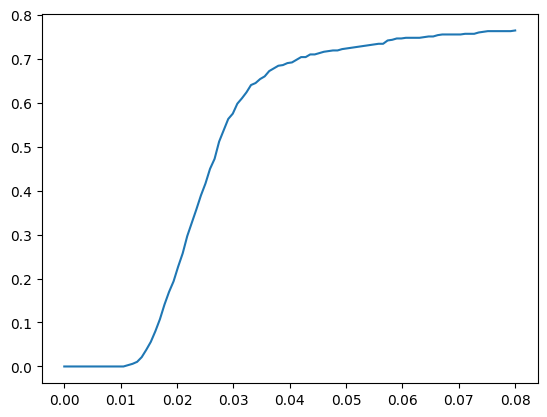

In [4]:
import matplotlib.pyplot as plt
thresholds = np.linspace(0, 0.08, 100)
ced_curve = np.array([np.mean(ceds < thr) for thr in thresholds])
plt.plot(thresholds, ced_curve, label=f'dlib (AUC: {auc_dlib:.4f})')